In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

2023-08-21 11:46:49:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /data/tmp. Using root: /data/tmp/tmph96hhdvm


### Configuration

In [3]:
VALIDATION_SITES = ["Ken_Banda", "Sone_Rohtas"]
TILE_SIZE = 110

import albumentations as A
AUGMENTATION_TRAIN = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=3)
])

EXPERIMENT_DIR = '../out/0816'
# EXPERIMENT_DIR = '../out/0809-UNetOriginal'

BATCH_SIZE = 256
LR = 3e-2

MODEL_TYPE = 'small'


### Create Rastervision datasets

In [7]:
from torch.utils.data import ConcatDataset

from utils.rastervision_utils import observation_to_scene_s1s2, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_scene
from utils.data_management import observation_factory

from project_config import S2_CHANNELS


def is_validation(scene):
    return any(
        [validation_site in scene.id
         for validation_site in VALIDATION_SITES]
    )

def is_training(scene):
    return not is_validation(scene)


all_observations = observation_factory(gcp_client)
all_scenes = list(map(
    lambda observation: observation_to_scene_s1s2(observation),
    all_observations
))

for scene in all_scenes:
    warn_if_nan_in_raw_scene(scene)

training_scenes = filter(is_training, all_scenes)
validation_scenes = filter(is_validation, all_scenes)

training_datasets = list(map(
    lambda scene: scene_to_training_ds(scene, TILE_SIZE, AUGMENTATION_TRAIN),
    training_scenes
))
validation_datasets = list(map(
    lambda scene: scene_to_validation_ds(scene, TILE_SIZE),
    validation_scenes
))
assert len(training_datasets) + len(validation_datasets) == len(all_scenes)

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)


2023-08-18 11:34:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmpqj8xbvaq/cache/http/storage.googleapis.com/sand_mining_median/labels/Betwa_Hamirpur_79-81_25-91_median/s2/Betwa_Hamirpur_79-81_25-91_2022-02-01_s2.tif.
2023-08-18 11:34:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmpqj8xbvaq/cache/http/storage.googleapis.com/sand_mining_median/labels/Betwa_Hamirpur_79-81_25-91_median/s1/Betwa_Hamirpur_79-81_25-91_2022-02-01_s1.tif.
2023-08-18 11:34:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmpqj8xbvaq/cache/http/storage.googleapis.com/sand_mining_median/labels/Betwa_Hamirpur_79-81_25-91_median/annotations/Betwa_Hamirpur_79-81_25-91_2022-02-01_annotations.geojson.
2023-08-18 11:34:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/tmpqj8xbvaq/cache/http/storage.googleapis.com/sand_mining_median/labels/Betwa_Hamirpur_79-81_25-91_median/s2/Betwa_Hamirpur_79-81

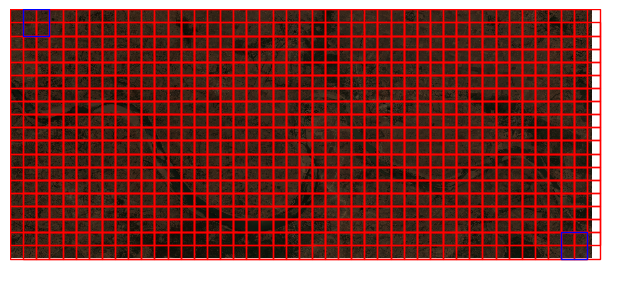

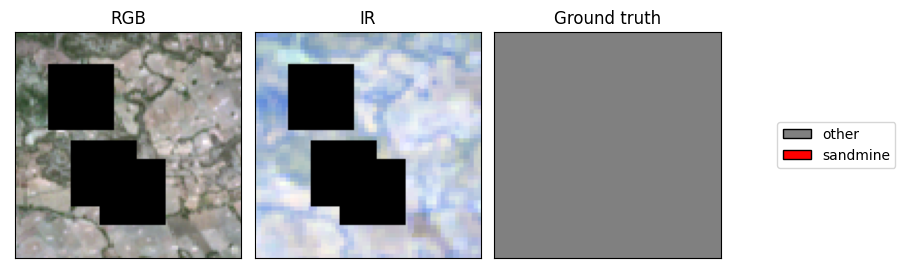

In [5]:
from utils.visualizing import show_windows, show_image_in_dataset
from project_config import DISPLAY_GROUPS, CLASS_CONFIG

ds_to_visualize = training_datasets[2]
show_windows(
    ds_to_visualize.scene.raster_source[:,:],
    ds_to_visualize.windows
)
show_image_in_dataset(
    ds_to_visualize,
    CLASS_CONFIG,
    DISPLAY_GROUPS,
)

# Train

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# torch.cuda.empty_cache()

In [9]:
from utils.rastervision_utils import construct_semantic_segmentation_learner
from models.unet.unet_small import UNetSmall
from models.unet.unet_original import UNet

_, _, n_channels = training_datasets[0].scene.raster_source.shape
n_classes = 2

if MODEL_TYPE == 'small':
    from models.unet.unet_small import UNetSmall
    model = UNetSmall(n_channels, n_classes)

else:
    from models.unet.unet_original import UNet
    model = UNet(n_channels, n_classes)



learner = construct_semantic_segmentation_learner(
    model=model,
    training_ds=train_dataset_merged,
    validation_ds=val_dataset_merged,
    batch_size=BATCH_SIZE,
    learning_rate=LR,
    # class_loss_weights=[1., 10.],
    experiment_dir=EXPERIMENT_DIR
)
learner.log_data_stats()

2023-08-18 11:36:58:rastervision.pytorch_learner.learner: INFO - train_ds: 9715 items
2023-08-18 11:36:58:rastervision.pytorch_learner.learner: INFO - valid_ds: 3078 items


## Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [10]:
learner.train(epochs=1)
learner.save_model_bundle()

2023-08-18 11:37:05:rastervision.pytorch_learner.learner: INFO - epoch: 0


Training:   0%|          | 0/38 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

2023-08-18 11:54:08:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9348675608634949,
 'avg_precision': 0.9144183993339539,
 'avg_recall': 0.9562522768974304,
 'epoch': 0,
 'other_f1': 0.9776369333267212,
 'other_precision': 0.9562522768974304,
 'other_recall': 1.0,
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_loss': 0.0005907453339675377,
 'train_time': '0:12:50.618400',
 'val_loss': 0.0011667641811072826,
 'valid_time': '0:04:12.209088'}
2023-08-18 11:54:08:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2023-08-18 11:54:08:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2023-08-18 11:54:09:rastervision.pytorch_learner.learner: INFO - Saving bundle to ../out/0816/model-bundle.zip.


# Tensorboard

To activate tensorboard, run the following command in the terminal:
`conda activate rastervision` (or whatever your conda environment is called)

`tensorboard --logdir sandmining-watch/out/<EXPERIMENT_DIR>` (make sure it's relative to your current path in the terminal)

You will also need to port-forward; on your local machine, run:

`ssh -N -f -L localhost:6006:localhost:6006 <USERNAME>@fati.ischool.berkeley.edu`

Note: this is not needed if you're running from within VS Code- it should automatically give you the option to open tensorboard in the browser.